# Content-Based Book Recommendation System¶

This notebook presents a content-based book recommendation system. The solution is presented as an algorithm using TF-IDF vectorizer and cosine similarity matrix.

## Data Loading

In [1]:
import pandas as pd

train = pd.read_csv('../data/interim/train.csv')

train.head()

,user_id,book_id,rating
0,10714,7164,3
1,48091,2213,3
2,9809,5769,4
3,25191,86,5
4,25441,4884,3


In [2]:
test = pd.read_csv('../data/interim/test.csv')

test.head()

,user_id,book_id,rating
0,42562,2757,3
1,43232,134,4
2,37244,1463,5
3,53366,71,2
4,29634,3339,4


In [3]:
books_information = pd.read_csv('../data/interim/books_information.csv')

books_information.head()

,book_id,authors,original_publication_year,title,average_rating,image_url
0,1,Suzanne Collins,2008.0,"The Hunger Games (The Hunger Games, #1)",4.34,https://images.gr-assets.com/books/1447303603m...
1,2,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Sorcerer's Stone (Harry P...,4.44,https://images.gr-assets.com/books/1474154022m...
2,3,Stephenie Meyer,2005.0,"Twilight (Twilight, #1)",3.57,https://images.gr-assets.com/books/1361039443m...
3,4,Harper Lee,1960.0,To Kill a Mockingbird,4.25,https://images.gr-assets.com/books/1361975680m...
4,5,F. Scott Fitzgerald,1925.0,The Great Gatsby,3.89,https://images.gr-assets.com/books/1490528560m...


## Content based system

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

In [5]:
features = ['average_rating', 'original_publication_year', 'authors']

books_information['text_features'] = books_information[features].astype(str).agg(' '.join, axis=1)

In [6]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

In [7]:
# Fit and transform the training data
tfidf_matrix = tfidf_vectorizer.fit_transform(books_information['text_features'])

In [8]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## Visualization of the similarity matrix

In [27]:
book_names = list(books_information['title'][:20].values)

In [30]:
books_similarities = pd.DataFrame(cosine_sim[:20, :20], index = book_names,
                  columns = book_names)

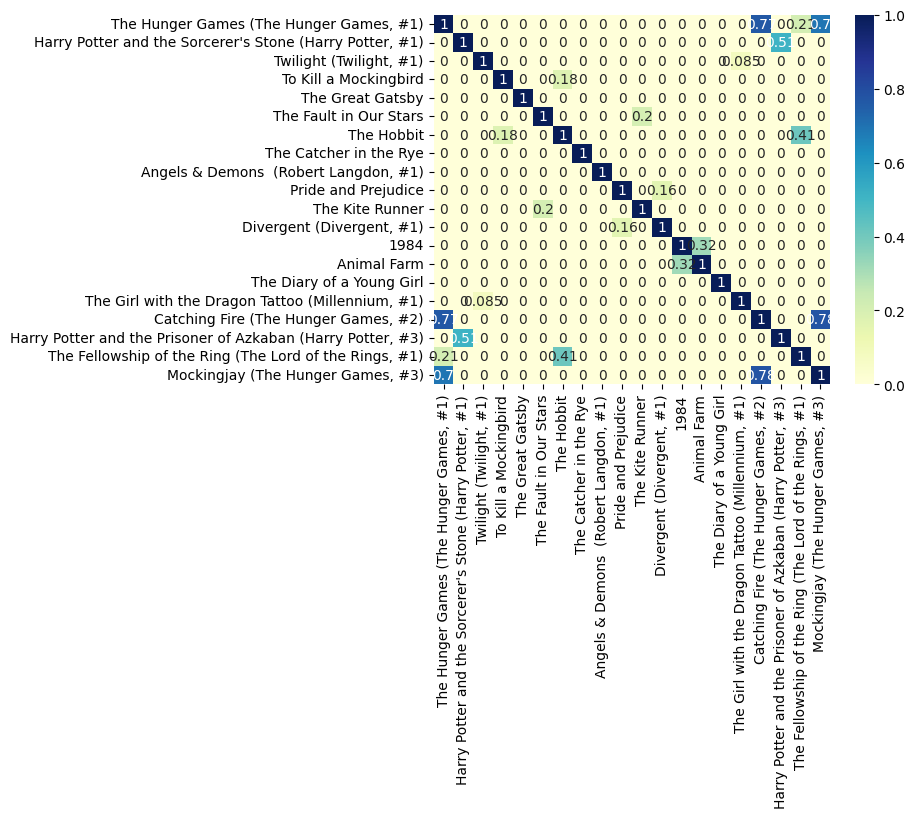

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(books_similarities, annot=True, cmap="YlGnBu")
plt.show()

## Evaluation

In [9]:
# Function to calculate Root Mean Squared Error (RMSE)
def calculate_rmse(predictions, targets):
    return np.sqrt(mean_squared_error(predictions, targets))

In [10]:
def predict_ratings(train, test, cosine_sim):
    predicted_ratings = []

    for _, row in test.iterrows():
        user_id = row['user_id']
        book_id = row['book_id']

        # Extract ratings for the current user from the training data
        user_ratings = train[train['user_id'] == user_id]

        # Calculate the weighted sum of ratings based on user similarities
        weighted_sum = 0
        similarity_sum = 0

        for _, rated_book in user_ratings.iterrows():
            rated_book_id = rated_book['book_id']
            rated_book_rating = rated_book['rating']

            # Calculate similarity between the target book and already rated books
            similarity = cosine_sim[book_id-1][rated_book_id-1]

            # Add the weighted contribution to the sum
            weighted_sum += similarity * rated_book_rating
            similarity_sum += abs(similarity)

        # Avoid division by zero
        if similarity_sum > 0.25:
            predicted_rating = weighted_sum / similarity_sum
        else:
            predicted_rating = 3

        predicted_ratings.append(predicted_rating)

    return predicted_ratings

### Evaluation on test data

In [11]:
test1 = test[:1000]

predicted_ratings = predict_ratings(train, test1, cosine_sim)

# Add the predicted ratings to the test_data DataFrame
test1['predicted_rating'] = predicted_ratings

C:\Users\User\AppData\Local\Temp\ipykernel_2916\2474903317.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['predicted_rating'] = predicted_ratings


In [12]:
# Calculate RMSE
rmse = calculate_rmse(test1['predicted_rating'], test1['rating'])
print(f"RMSE: {rmse}")

RMSE: 0.9577367227181034


### Evaluation on highly rated books

In [13]:
test2 = test[test["rating"] > 3][:1000]

predicted_ratings = predict_ratings(train, test2, cosine_sim)

# Add the predicted ratings to the test_data DataFrame
test2['predicted_rating'] = predicted_ratings

In [14]:
# Calculate RMSE
rmse = calculate_rmse(test2['predicted_rating'], test2['rating'])
print(f"RMSE: {rmse}")

RMSE: 0.8993452179939782


## Test

In [ ]:
def recommend_books_content_based(user_ratings, cosine_sim):
    # Get the list of all books
    all_books = books_information['book_id'].unique()

    predict_data = pd.DataFrame([book_id for book_id in all_books
                                 if book_id not in user_ratings['book_id']],
                                columns=['book_id'])

    # Use the cosine similarity to predict ratings
    for i, book_id in enumerate(predict_data['book_id']):
        similarity_scores = cosine_sim[book_id-1]
        
        
        weighted_sum = 0
        similarity_sum = 0

        for _, rated_book in user_ratings.iterrows():
            similarity = similarity_scores[rated_book['book_id'] - 1]
            weighted_sum += similarity * rated_book['rating']
            similarity_sum += abs(similarity)

        if similarity_sum > 0.4:
#             similarity_sum = max(0.7, similarity_sum)
            predict_data.at[i, 'predicted_rating'] = weighted_sum / similarity_sum
            
        else:
            predict_data.at[i, 'predicted_rating'] = 1
            
    predict_data = predict_data[~predict_data['book_id'].isin(user_ratings['book_id'])]

    return predict_data[['book_id', 'predicted_rating']]

In [ ]:
def top_recommend_books(user_ratings, cosine_sim, num_recommendations=5):
    predict_data = recommend_books_content_based(user_ratings, cosine_sim)
    top_recommendations = predict_data.sort_values(by='predicted_rating', ascending=False).head(num_recommendations)
    recommended_book_ids = top_recommendations['book_id']
    return books_information[books_information['book_id'].isin(recommended_book_ids)][['authors', 'original_publication_year', 'title']]

In [ ]:
user_ratings = pd.DataFrame({  
    'book_id': [1, 2, 3, 4, 15, 4640, 3093, 8, 9, 10],
    'rating': [5, 5, 3, 5, 5, 1, 5, 5, 3, 4]
})


In [ ]:
# Example: Get top 5 recommendations for the user's ratings
top_recommendations = top_recommend_books(user_ratings, cosine_sim, num_recommendations=5)

print("Top 5 Recommended Books:")
top_recommendations